##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# MoveNet: Ultra fast and accurate pose detection model.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/movenet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

**[MoveNet](https://t.co/QpfnVL0YYI?amp=1)** is an ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on [TF Hub](https://tfhub.dev/s?q=movenet) with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.


<img src="https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/combined_squat_dance.gif" alt="drawing"/>

*Images downloaded from Pexels (https://www.pexels.com/)

This Colab walks you through the details of how to load MoveNet, and run inference on the input image and video below.

Note: check out the [live demo](https://storage.googleapis.com/tfjs-models/demos/pose-detection/index.html?model=movenet) for how the model works!

# Human Pose Estimation with MoveNet

## Visualization libraries & Imports

In [9]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [4]:
!pip install tensorflow_hub

You should consider upgrading via the 'c:\users\mynam\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [8]:
!pip install -q git+https://github.com/tensorflow/docs

You should consider upgrading via the 'c:\users\mynam\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [97]:
!pip install PySimpleGUI

You should consider upgrading via the 'c:\users\mynam\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [24]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [25]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, fps=fps)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Model from TF hub

In [11]:
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

## Single Image Example

This session demonstrates the minumum working example of running the model on a **single image** to predict the 17 human keypoints.

### Load Input Image

In [12]:
!curl -o input_image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg --silent

In [13]:
# Load the input image.
image_path = 'input_image.jpeg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

### Run Inference

[[[[0.33042657 0.5736354  0.3410947 ]
   [0.31431746 0.5788823  0.6316645 ]
   [0.31177807 0.5540118  0.5416582 ]
   [0.31943363 0.55942917 0.26764265]
   [0.3173316  0.5019597  0.45877433]
   [0.41172826 0.5477337  0.4475956 ]
   [0.4112252  0.4398402  0.6417166 ]
   [0.5040371  0.65642345 0.49174607]
   [0.50825906 0.52889967 0.6424118 ]
   [0.42195302 0.64256525 0.50347805]
   [0.41878182 0.6188389  0.559379  ]
   [0.60323143 0.4146117  0.5731188 ]
   [0.607028   0.3212454  0.70394814]
   [0.65013444 0.56234217 0.53305596]
   [0.6837263  0.42692038 0.65667844]
   [0.83761466 0.5191805  0.44044107]
   [0.89829147 0.35492843 0.59402674]]]]


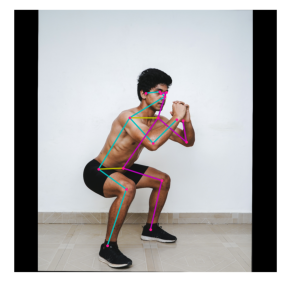

In [27]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

print(keypoints_with_scores)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [15]:
for feature in keypoints_with_scores.squeeze():
    print(feature[1])
    break

0.5736354


#Yoga Dataset - Loading 


# Code Begins Here

In [17]:
import os
import imageio as iio
from tqdm import tqdm
import time

import pandas as pd
from PIL import Image

In [18]:
all_channels = ['RGBA','CMYK', 'RGBA']
def image_reader_folder(path):
    images_list = os.listdir(path)
    image_read_list = []
    for image in images_list:
        image_read = Image.open(path+"/"+image)
        if(str(image_read.mode)  in all_channels ):
            image_read = image_read.convert('RGB')
        
        #image_read = iio.imread(path + '/' + image )
        image_read_list.append(image_read)
    return image_read_list

In [19]:
def pose_detector(image, label):
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    keypoints_with_scores = movenet(input_image)
    feature_list = []
    for feature in keypoints_with_scores.squeeze():
        feature_list.append(feature[0])
        feature_list.append(feature[1])
    feature_list.append(label)
    return feature_list
        

In [20]:
list_coords = []
path_images_test = '../input/yoga-poses-dataset/DATASET/TEST/'
path_images_train = '../input/yoga-poses-dataset/DATASET/TRAIN/'
pose_names = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

count = 0 
for pose in pose_names:
    path = path_images_test + pose
    image_list = image_reader_folder(path)
    for image in tqdm(image_list):
        try:
            list_coords.append(pose_detector(image, pose))
        except Exception as e:
            print(e)
            print(image)
            count+=1
            continue 
print("Images with errors")
print(count)
#temp[:5]

 55%|█████▌    | 44/80 [00:01<00:01, 32.73it/s]

output dimensions must be positive [Op:ResizeBilinear]
<PIL.PngImagePlugin.PngImageFile image mode=P size=900x700 at 0x7F24CF0D5150>


 20%|██        | 23/115 [00:00<00:03, 24.00it/s]

output dimensions must be positive [Op:ResizeBilinear]
<PIL.PngImagePlugin.PngImageFile image mode=P size=1100x734 at 0x7F24BC118FD0>


 50%|████▉     | 57/115 [00:02<00:02, 24.03it/s]

output dimensions must be positive [Op:ResizeBilinear]
<PIL.PngImagePlugin.PngImageFile image mode=P size=600x400 at 0x7F24BC0C0890>


 53%|█████▎    | 61/115 [00:02<00:02, 26.81it/s]

output dimensions must be positive [Op:ResizeBilinear]
<PIL.PngImagePlugin.PngImageFile image mode=P size=1100x734 at 0x7F28F376D6D0>


100%|██████████| 115/115 [00:06<00:00, 17.52it/s]


output dimensions must be positive [Op:ResizeBilinear]
<PIL.PngImagePlugin.PngImageFile image mode=P size=600x400 at 0x7F24CF0BB890>


 14%|█▍        | 15/109 [00:00<00:03, 25.99it/s]

output dimensions must be positive [Op:ResizeBilinear]
<PIL.PngImagePlugin.PngImageFile image mode=P size=1920x1282 at 0x7F24BC0B19D0>


100%|██████████| 109/109 [00:04<00:00, 26.18it/s]

Images with errors
6


In [21]:
#Defnining headers here with their key value pairs for identifying joings in human body
headers = {'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16 
            }

# Preprocessing

In [22]:

col_names = []
for x in headers.keys():
    col_names.append(x + '_x')
    col_names.append(x + '_y')
col_names.append('target')

In [23]:
#col_names = []
df_final = pd.DataFrame(list_coords, columns = col_names)
df_final.head()

df_final.to_csv('dataset.csv')

In [24]:
Image.open('../input/yoga-poses-dataset/DATASET/TEST/downdog/00000010.png').mode

'RGBA'

## Video (Image Sequence) Example

This section demonstrates how to apply intelligent cropping based on detections from the previous frame when the input is a sequence of frames. This allows the model to devote its attention and resources to the main subject, resulting in much better prediction quality without sacrificing the speed.


In [25]:
#@title Cropping Algorithm

# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }

def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.

  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] >
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] >
           MIN_CROP_KEYPOINT_SCORE))

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.

  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x

  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y

    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]

def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.

  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] +
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] +
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)

    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)

def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  return output_image

def run_inference(movenet, image, crop_region, crop_size):
  """Runs model inferece on the cropped region.

  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  # Run model inference.
  keypoints_with_scores = movenet(input_image)
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height +
        crop_region['height'] * image_height *
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width +
        crop_region['width'] * image_width *
        keypoints_with_scores[0, 0, idx, 1]) / image_width
  return keypoints_with_scores

### Load Input Image Sequence

In [26]:
!wget -q -O dance.gif https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/dance_input.gif

In [27]:
# Load the input image.
image_path = 'dance.gif'
image = tf.io.read_file(image_path)
image = tf.image.decode_gif(image)

### Run Inference with Cropping Algorithm


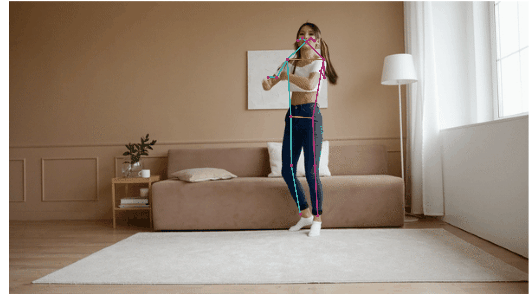

In [28]:
# Load the input image.
num_frames, image_height, image_width, _ = image.shape
crop_region = init_crop_region(image_height, image_width)

output_images = []
bar = display(progress(0, num_frames-1), display_id=True)
for frame_idx in range(num_frames):
  keypoints_with_scores = run_inference(
      movenet, image[frame_idx, :, :, :], crop_region,
      crop_size=[input_size, input_size])
  output_images.append(draw_prediction_on_image(
      image[frame_idx, :, :, :].numpy().astype(np.int32),
      keypoints_with_scores, crop_region=None,
      close_figure=True, output_image_height=300))
  crop_region = determine_crop_region(
      keypoints_with_scores, image_height, image_width)
  bar.update(progress(frame_idx, num_frames-1))

# Prepare gif visualization.
output = np.stack(output_images, axis=0)
to_gif(output, fps=10)

# Notebook - Google Colab 

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn import preprocessing

# first neural network with keras make predictions
from numpy import loadtxt
from tensorflow.keras.models import Sequential,model_from_json
from tensorflow.keras.layers import Dense
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from tensorflow.keras.optimizers  import SGD, Adam, Adadelta, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [22]:
df = df_final
#Cleaning the data here with nose, ear and eye which is not needed
points_to_remove = ['nose','ear','eye']
for c in df.columns:
       for point in points_to_remove:
         if(point in c):
           print("Drop : ",c)
           df.drop(c, axis=1, inplace=True)
            
#Separating X and Y data 
X = df.drop(columns=['target'])
y_temp = df['target']

#Peparing 
le = preprocessing.LabelEncoder()
y = le.fit_transform(y_temp)

Drop :  nose_x
Drop :  nose_y
Drop :  left_eye_x
Drop :  left_eye_y
Drop :  right_eye_x
Drop :  right_eye_y
Drop :  left_ear_x
Drop :  left_ear_y
Drop :  right_ear_x
Drop :  right_ear_y


In [23]:
le.fit(y_temp)
le_name_mapping = dict(zip(le.transform(le.classes_),le.classes_, ))
le_name_mapping

{0: 'downdog', 1: 'goddess', 2: 'plank', 3: 'tree', 4: 'warrior2'}

In [24]:
#Model 2 for prediction
# load json and create model
json_model = '../input/saved-model/model.json'
model_h5 = '../input/saved-model/model.h5'
json_file = open(json_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_h5)
print("Loaded model from disk")

# evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
loaded_model.compile(Adam(lr = 0.01), "sparse_categorical_crossentropy", metrics = ["accuracy"])
score = loaded_model.evaluate(X, y, verbose=0)

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


accuracy: 81.25%


In [29]:
path_to_test_image = '../input/goddesstest'

In [30]:
test_images = image_reader_folder(path_to_test_image)
test_images

FileNotFoundError: [Errno 2] No such file or directory: '../input/goddesstest'

In [ ]:
all_coords = [ ]
for image in test_images:
       coords =  pose_detector(image, 'label')
       all_coords.append(coords)

In [26]:
df_final = pd.DataFrame(all_coords, columns = col_names)
df_final.head()

NameError: name 'all_coords' is not defined

In [ ]:
df = df_final
#Cleaning the data here with nose, ear and eye which is not needed
points_to_remove = ['nose','ear','eye']
for c in df.columns:
       for point in points_to_remove:
         if(point in c):
           print("Drop : ",c)
           df.drop(c, axis=1, inplace=True)
            
#Separating X and Y data 
X_downloaded = df.drop(columns=['target'])

In [ ]:
y_pred_downloaded = loaded_model.predict(X_downloaded)
np.argmax(y_pred_downloaded , axis=1)

# ML Training - using Movenet Data Points 
Ownership 
EDA 

Model Training

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn import preprocessing

# first neural network with keras make predictions
from numpy import loadtxt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from keras.optimizers import SGD, Adam, Adadelta, RMSprop

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

ImportError: cannot import name 'SGD' from 'keras.optimizers' (/opt/conda/lib/python3.7/site-packages/keras/optimizers.py)

In [ ]:
df = pd.read_csv("/content/sample_data/dataset.csv",)

In [ ]:
df.index = df['Unnamed: 0']
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
#Cleaning the data here with nose, ear and eye which is not needed
points_to_remove = ['nose','ear','eye']
for c in df.columns:
       for point in points_to_remove:
         if(point in c):
           print("Drop : ",c)
           df.drop(c, axis=1, inplace=True)

In [ ]:
df.target.value_counts().plot(kind='barh')
plt.title("Distribution of the data ")
plt.xlabel("Count of the Poses")
plt.ylabel("Target Labels")
plt.show()

In [ ]:
#Separating X and Y data 
X = df.drop(columns=['target'])
y_temp = df['target']

In [ ]:
#Peparing 
le = preprocessing.LabelEncoder()
#print(y_temp)
y = le.fit_transform(y_temp)
print(y)

In [ ]:
import sklearn 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [ ]:
model = Sequential()
model.add(Dense(24,  activation = "relu"))
model.add(Dense(17, activation = "relu"))
# model.add(Dropout(0.2))
model.add(Dense(10, activation = "relu"))
model.add(Dense(5, activation = "softmax"))
model.compile(Adam(lr = 0.01), "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
model.fit(X_train, y_train, verbose=1, epochs=50)

In [ ]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
confusion_matrix(y_test, y_pred_classes)

In [ ]:
print(classification_report(y_test, y_pred_classes))

In [ ]:
model.summary()

In [ ]:
plt.matshow(df.corr())
plt.show()

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
search = '_x'
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=20)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

# Experimentation & Research on various models - 1st : Model using Pure CNN based architecture 
Ownership : Vritansh Kamal(vk2501

In [32]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import zipfile
#from google.colab import drive
from tensorflow import keras
from keras import layers
from PIL import ImageFile
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
      tf.config.experimental.list_physical_devices(gpu)

In [ ]:
zip_paths = ['/content/drive/MyDrive/archive (26).zip']
train_data = tf.constant(zip_paths)
train_data = tf.data.Dataset.from_tensor_slices(train_data)

In [ ]:
# drive.mount('/content/drive/') Run below code only when running on Google colaboratory
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive (26).zip", 'r')
zip_ref.extractall("/content/sample_data")
zip_ref.close()

In [ ]:
data_dir_train = "/content/sample_data/DATASET/TRAIN"
data_dir_test = "/content/sample_data/DATASET/TEST"

size = 256
img_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # vertical_flip=True,
)

X_train = img_gen_train.flow_from_directory(data_dir_train,
                                        batch_size=32,
                                        target_size=(size, size),
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        subset='training'
                                        )

X_val = img_gen_train.flow_from_directory(data_dir_train,
                                        batch_size=32,
                                        target_size=(size, size),
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        subset='validation'
                                        )

img_gen_test = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # vertical_flip=True,
)

X_test = img_gen_test.flow_from_directory(data_dir_test,
                                        batch_size=32,
                                        target_size=(256, 256),
                                        class_mode='categorical',
                                        color_mode='rgb'
                                        )

In [ ]:
#Showing a random image
plt.imshow(X_train[1][0][22])
plt.show()

In [ ]:
print(X_train.class_indices)
print(X_test.class_indices)

In [ ]:
model = keras.Sequential(
    [
        layers.Conv2D(filters=16,kernel_size=(5,5),strides=1, activation="relu",name = "ConvolutionLayer1",input_shape=(256, 256, 3)),
        layers.MaxPool2D(),

        layers.Conv2D(filters=32,kernel_size=(5,5),strides=1, activation="relu",name = "ConvolutionLayer2"),
        layers.MaxPool2D(),
     
        layers.Conv2D(filters=16,kernel_size=(5,5),strides=1, activation="relu",name = "ConvolutionLayer3"),
        layers.MaxPool2D(),
     
        layers.Conv2D(filters=32,kernel_size=(5,5),strides=1, activation="relu",name = "ConvolutionLayer4"),
        layers.MaxPool2D(),
     
        layers.Conv2D(filters=16,kernel_size=(5,5),strides=1, activation="relu",name = "ConvolutionLayer5"),
        layers.MaxPool2D(),  
        
        layers.GlobalAveragePooling2D(),
     
        layers.Dense(112, activation="relu", name="layer1"),
        layers.Dropout(.2),
        layers.Dense(256, activation="relu", name="layer2"),
        layers.Dropout(.2),
        layers.Dense(112, activation="relu", name="layer3"),

        # layers.Dense(32, activation="relu", name="layer2"),      
        layers.Dense(5 , name="output", activation="softmax"),
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, validation_data=X_val, epochs=40, batch_size=32 )

In [ ]:
model.evaluate(X_test)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Opencv Code here

In [269]:
# manually calculating cosine to get the value with coordinates
def cosine(x1, y1, x0, y0, x2, y2):
    
    #shifting origin to get the vector
    x_1, y_1 = x1 - x0, y1 - y0
    x_2, y_2 = x2 - x0, y2 - y0
    
    #returning cosine
    return (x_2*x_1) + (y_2*y_1) / ((x_1)**2 + (y_1)**2)**0.5 * ((x_2)**2 + (y_2)**2)**0.5

In [270]:
# loading the prediction model
json_model = 'model/model.json'
model_h5 = 'model/model.h5'
json_file = open(json_model, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_h5)
print("Loaded model from disk")

Loaded model from disk


In [271]:
loaded_model.compile(Adam(lr = 0.01), "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [272]:
target_pose_names = ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior']

In [273]:
from imutils import resize


In [274]:
def WebCam(chosen):
    # capture video from webcam
    capture = cv2.VideoCapture(0)
    
    # run a loop to get all the frames
    while capture.isOpened():
        
        # reading the frames one by one
        ret, frame = capture.read()
        
        # prepping the frame for input in the model
        input_image = tf.expand_dims(frame.copy(), axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
        
        # running the input through movenet to get coordinates of joints
        keypoints_with_scores = movenet(input_image)
        
        feature_list = []
        # to get x and y of each joint separately
        for feature in keypoints_with_scores.squeeze()[5:]:
            feature_list.append(feature[0])
            feature_list.append(feature[1])
        # making it a dataframe for input in the classification model
        input_model = pd.DataFrame(feature_list).T
        
        # getting the index of the max probability and then using it to get the detected pose
        detected_pose = target_pose_names[np.argmax(loaded_model.predict(input_model))]
        
        # putting the detected pose as text on the video display
        cv2.putText(frame, 'Detected Yoga Pose:', (350, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.85, (255, 255, 255), 2, cv2.LINE_8)
        cv2.putText(frame, detected_pose, (450, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_4)
        
        
        cv2.putText(frame, "Press 'q' to quit.",  (10, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2, cv2.LINE_8)
        
        # if the option chosen is not manual, then constantly checking when the chosen pose is detected
        if chosen != 'Manual':
            # keeping the original text color as red
            color = (0, 0, 255)
            skip = False
            
            # if the detected pose is chosen pose, changing the color to green
            if chosen == detected_pose:
                color = (0, 255, 0)
                skip = True  # this variable is here for checking if downdog is selected and achieved
            cv2.putText(frame, 'Goal: '+str(chosen), (350, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.85, color, 2, cv2.LINE_8)
            
            # if downdog is selected then this feedback loop runs
            # if downdod is achieved then it doesn't go inside this loop
            if chosen == 'Downdog' and not(skip):
                feedback = 'Downward dog in progress'
                
                # first checking if the coordinates of shoulders are above the hip
                if feature_list[1] < feature_list[9]:
                    feedback = 'Start by bending down'
                    
                # then checking if the hip angle resides within the threshold range
                elif cosine(feature_list[6], feature_list[7], 
                            feature_list[14], feature_list[15], 
                            feature_list[18], feature_list[19]) < 0.04:
                    feedback = 'Bring hands closer to feet'
                elif cosine(feature_list[6], feature_list[7], 
                            feature_list[14], feature_list[15], 
                            feature_list[18], feature_list[19]) < 0.09:
                    feedback = 'Put hands further away from feet'
                
                # putting the feedback text 
                cv2.putText(frame, feedback, (350, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 0), 2, cv2.LINE_8)
        
        # displaying the joints on the image 
        display_image = tf.expand_dims(frame, axis=0)
        display_image = tf.cast(tf.image.resize_with_pad(display_image, 1280, 1280), dtype=tf.int32)
        output_overlay = draw_prediction_on_image(np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)
        
        # displaying live footage with all the overlays and texts
        cv2.imshow('Webcam footage', output_overlay)
        
        # check to quit the webcam window
        if cv2.waitKey(10)& 0xFF==ord('q'):
            break
    capture.release()

    cv2.destroyAllWindows()

In [275]:
import PySimpleGUI as sg

# using PySimpleGUI to get input from the user
event, values = sg.Window('Choose an option', [[sg.Text('Yoga Poses ->'), sg.Listbox(target_pose_names + ['Manual'] , size=(20, 6), key='LB')],
    [sg.Button('OK'), sg.Button('Cancel')]]).read(close=True)

if event == 'OK':
    try:
        chosen = values["LB"][0]
    except:
        chosen = 'Manual'
    WebCam(chosen)
    
else:
    sg.popup_cancel('User aborted')